In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
from tqdm import tqdm

import torch
import torch.nn as nn
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


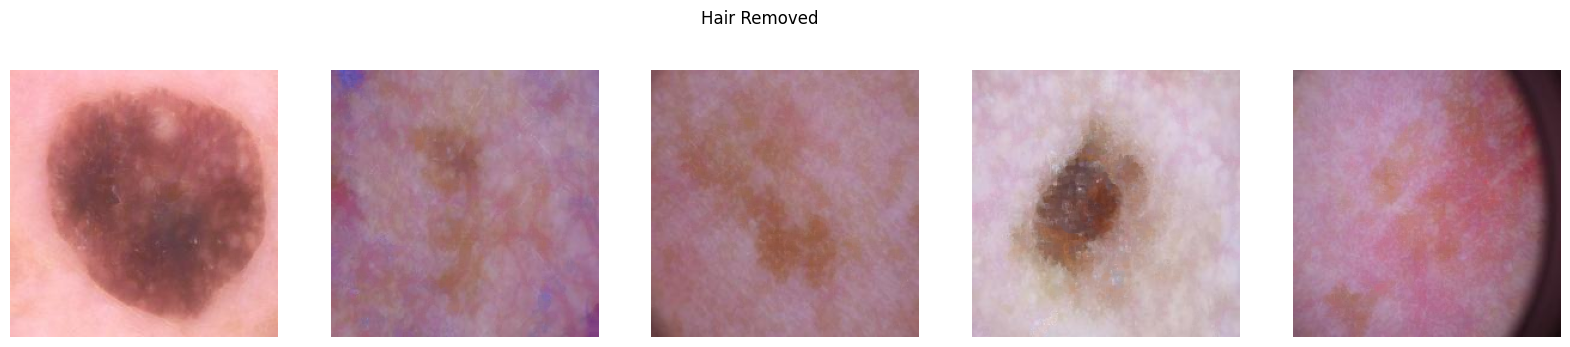

In [3]:
def remove_hair(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    kernel = cv2.getStructuringElement(1, (17, 17))
    blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, kernel)
    _, mask = cv2.threshold(blackhat, 10, 255, cv2.THRESH_BINARY)
    mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
    result = cv2.inpaint(img, cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY), 1, cv2.INPAINT_TELEA)
    return result

# Display 5 images
sample_paths = glob("/content/drive/MyDrive/ISIC Dataset/Train/Benign/*.jpg")[:5]
fig, axs = plt.subplots(1, 5, figsize=(20, 4))
for i, path in enumerate(sample_paths):
    img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
    no_hair = remove_hair(img)
    axs[i].imshow(no_hair)
    axs[i].axis('off')
plt.suptitle("Hair Removed")
plt.show()


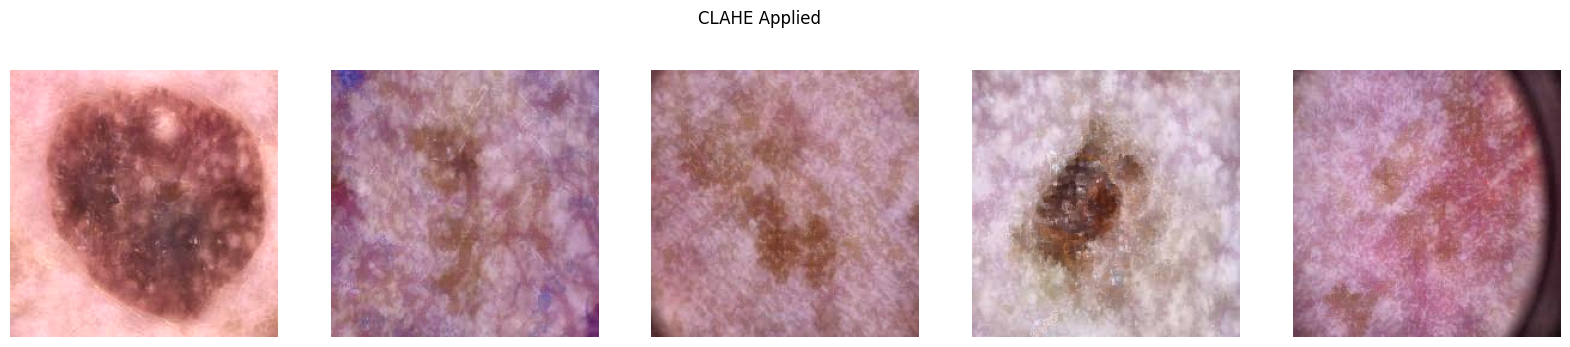

In [4]:
def apply_clahe(img):
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl, a, b))
    final = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)
    return final

# Display 5 images
fig, axs = plt.subplots(1, 5, figsize=(20, 4))
for i, path in enumerate(sample_paths):
    img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
    no_hair = remove_hair(img)
    eq = apply_clahe(no_hair)
    axs[i].imshow(eq)
    axs[i].axis('off')
plt.suptitle("CLAHE Applied")
plt.show()


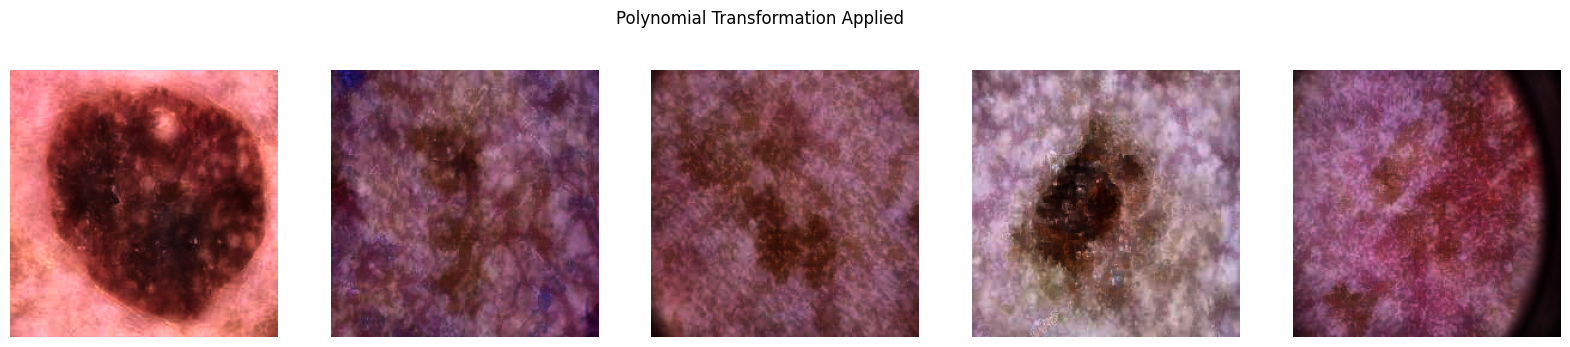

In [5]:
def poly_transform(img):
    img = img.astype(np.float32) / 255.0
    poly_img = np.power(img, 2.0)
    poly_img = (poly_img * 255).astype(np.uint8)
    return poly_img

# Display 5 images
fig, axs = plt.subplots(1, 5, figsize=(20, 4))
for i, path in enumerate(sample_paths):
    img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
    processed = poly_transform(apply_clahe(remove_hair(img)))
    axs[i].imshow(processed)
    axs[i].axis('off')
plt.suptitle("Polynomial Transformation Applied")
plt.show()


In [6]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset
from torchvision.io import read_image

class CustomSkinDataset(Dataset):
    def __init__(self, root_dir, transform=None, augment=False):
        self.dataset = ImageFolder(root_dir)
        self.transform = transform
        self.augment = augment

    def __getitem__(self, idx):
        img_path, label = self.dataset.imgs[idx]
        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        img = remove_hair(img)
        img = apply_clahe(img)
        img = poly_transform(img)
        img = Image.fromarray(img)
        if self.augment:
            img = self.transform(img)
        else:
            img = self.transform(img)
        return img, label

    def __len__(self):
        return len(self.dataset)

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.ToTensor()
])



In [7]:
# Load datasets
train_data = CustomSkinDataset("/content/drive/MyDrive/ISIC Dataset/Train", transform=train_transform, augment=True)
val_data = CustomSkinDataset("/content/drive/MyDrive/ISIC Dataset/Val", transform=test_transform)
test_data = CustomSkinDataset("/content/drive/MyDrive/ISIC Dataset/Test", transform=test_transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)
test_loader = DataLoader(test_data, batch_size=32)


In [9]:
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [10]:
best_acc = 0
for epoch in range(15):
    model.train()
    train_loss, correct, total = 0, 0, 0
    for imgs, labels in tqdm(train_loader):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_acc = 100. * correct / total
    print(f"Epoch {epoch+1}, Train Acc: {train_acc:.2f}%, Loss: {train_loss/len(train_loader):.4f}")

    # Validation
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for imgs, labels in tqdm(val_loader):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_acc = 100. * correct / total
    print(f"Validation Acc: {val_acc:.2f}%")

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")
        print("Best Model Saved")


100%|██████████| 84/84 [08:58<00:00,  6.41s/it]


Epoch 1, Train Acc: 81.81%, Loss: 0.3966


100%|██████████| 21/21 [03:50<00:00, 10.96s/it]


Validation Acc: 83.89%
Best Model Saved


100%|██████████| 84/84 [01:03<00:00,  1.32it/s]


Epoch 2, Train Acc: 88.27%, Loss: 0.2769


100%|██████████| 21/21 [00:11<00:00,  1.88it/s]


Validation Acc: 85.24%
Best Model Saved


100%|██████████| 84/84 [01:03<00:00,  1.32it/s]


Epoch 3, Train Acc: 89.99%, Loss: 0.2256


100%|██████████| 21/21 [00:10<00:00,  1.92it/s]


Validation Acc: 85.54%
Best Model Saved


100%|██████████| 84/84 [01:02<00:00,  1.34it/s]


Epoch 4, Train Acc: 91.82%, Loss: 0.1896


100%|██████████| 21/21 [00:10<00:00,  1.97it/s]


Validation Acc: 82.83%


100%|██████████| 84/84 [01:02<00:00,  1.34it/s]


Epoch 5, Train Acc: 92.79%, Loss: 0.1656


100%|██████████| 21/21 [00:10<00:00,  1.92it/s]


Validation Acc: 87.05%
Best Model Saved


100%|██████████| 84/84 [01:03<00:00,  1.33it/s]


Epoch 6, Train Acc: 94.70%, Loss: 0.1389


100%|██████████| 21/21 [00:10<00:00,  2.02it/s]


Validation Acc: 85.99%


100%|██████████| 84/84 [01:04<00:00,  1.30it/s]


Epoch 7, Train Acc: 95.82%, Loss: 0.1110


100%|██████████| 21/21 [00:10<00:00,  1.93it/s]


Validation Acc: 84.64%


100%|██████████| 84/84 [01:03<00:00,  1.33it/s]


Epoch 8, Train Acc: 96.94%, Loss: 0.0860


100%|██████████| 21/21 [00:11<00:00,  1.86it/s]


Validation Acc: 86.75%


100%|██████████| 84/84 [01:03<00:00,  1.33it/s]


Epoch 9, Train Acc: 95.78%, Loss: 0.1020


100%|██████████| 21/21 [00:10<00:00,  1.96it/s]


Validation Acc: 85.09%


100%|██████████| 84/84 [01:03<00:00,  1.32it/s]


Epoch 10, Train Acc: 95.85%, Loss: 0.0981


100%|██████████| 21/21 [00:11<00:00,  1.86it/s]


Validation Acc: 87.65%
Best Model Saved


100%|██████████| 84/84 [01:04<00:00,  1.30it/s]


Epoch 11, Train Acc: 97.61%, Loss: 0.0580


100%|██████████| 21/21 [00:11<00:00,  1.88it/s]


Validation Acc: 87.80%
Best Model Saved


100%|██████████| 84/84 [01:03<00:00,  1.33it/s]


Epoch 12, Train Acc: 97.95%, Loss: 0.0599


100%|██████████| 21/21 [00:11<00:00,  1.89it/s]


Validation Acc: 85.54%


100%|██████████| 84/84 [01:04<00:00,  1.31it/s]


Epoch 13, Train Acc: 97.91%, Loss: 0.0543


100%|██████████| 21/21 [00:11<00:00,  1.85it/s]


Validation Acc: 86.30%


100%|██████████| 84/84 [01:03<00:00,  1.32it/s]


Epoch 14, Train Acc: 97.16%, Loss: 0.0782


100%|██████████| 21/21 [00:11<00:00,  1.90it/s]


Validation Acc: 86.30%


100%|██████████| 84/84 [01:03<00:00,  1.33it/s]


Epoch 15, Train Acc: 97.95%, Loss: 0.0510


100%|██████████| 21/21 [00:11<00:00,  1.90it/s]

Validation Acc: 82.53%


In [11]:
# Load best model
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

y_true, y_pred = [], []
y_scores = []

with torch.no_grad():
    for imgs, labels in tqdm(val_loader):
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)  # logits or probabilities
        probs = torch.softmax(outputs, dim=1)[:, 1]  # get score for class 1 (Malignant)

        _, preds = outputs.max(1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        y_scores.extend(probs.cpu().numpy())

print(classification_report(y_true, y_pred, target_names=["Benign", "Malignant"]))


100%|██████████| 21/21 [00:11<00:00,  1.86it/s]

              precision    recall  f1-score   support

      Benign       0.91      0.85      0.88       339
   Malignant       0.85      0.91      0.88       325

    accuracy                           0.88       664
   macro avg       0.88      0.88      0.88       664
weighted avg       0.88      0.88      0.88       664



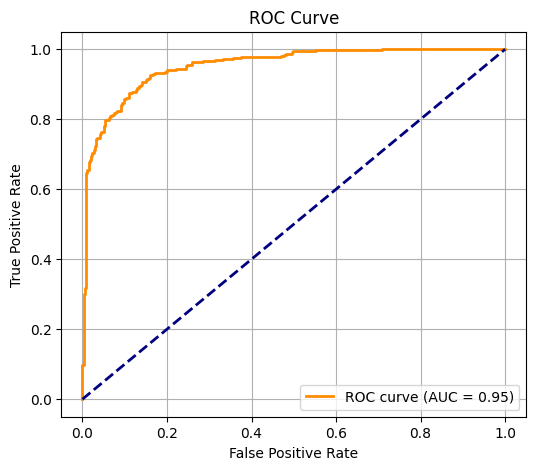

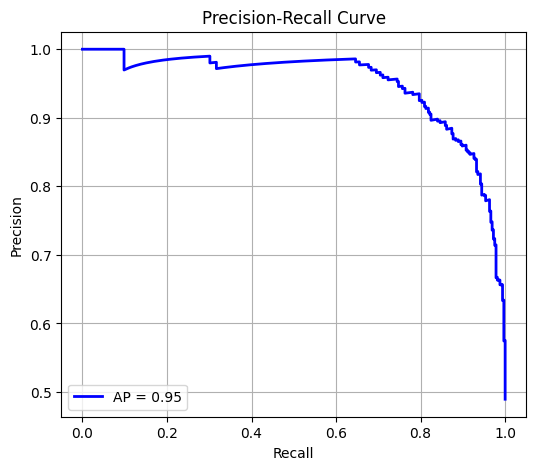

In [12]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_true, y_scores)
ap_score = average_precision_score(y_true, y_scores)

plt.figure(figsize=(6,5))
plt.plot(recall, precision, color='blue', lw=2, label=f'AP = {ap_score:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.grid(True)
plt.show()


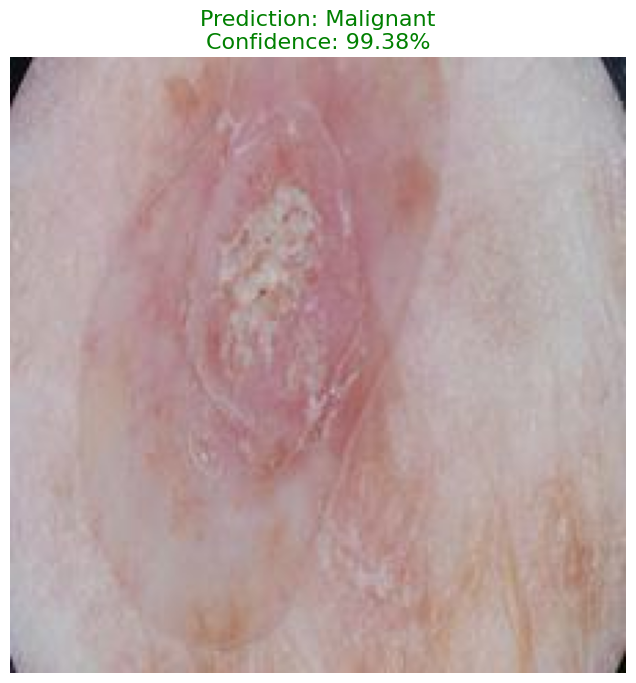

In [18]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import models
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from glob import glob
import random

# Configurar dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Clases
class_names = ["Benign", "Malignant"]


# Cargar modelo ResNet50
resnet = models.resnet50(pretrained=False)
resnet.fc = nn.Linear(resnet.fc.in_features, 2)
resnet.load_state_dict(torch.load("best_model.pth", map_location=device))
resnet = resnet.to(device).eval()

# Seleccionar una imagen aleatoria
all_test_paths = glob("/content/drive/MyDrive/ISIC Dataset/Test/*/*.jpg")
sample_path = random.choice(all_test_paths)

# Preprocesar imagen
def preprocess_image(path):
    img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
    img = remove_hair(img)
    img = apply_clahe(img)
    img = poly_transform(img)
    img = Image.fromarray(img)
    img = test_transform(img)
    return img.unsqueeze(0)  # Añadir dimensión batch

# Hacer inferencia
img_tensor = preprocess_image(sample_path).to(device)

with torch.no_grad():
    outputs = resnet(img_tensor)
    probabilities = torch.softmax(outputs, dim=1)
    confidence, predicted_class = torch.max(probabilities, 1)

predicted_label = class_names[predicted_class.item()]
confidence_score = confidence.item()

# Mostrar resultados
img_disp = cv2.cvtColor(cv2.imread(sample_path), cv2.COLOR_BGR2RGB)

plt.figure(figsize=(8, 8))
plt.imshow(img_disp)
plt.axis('off')
plt.title(f"Prediction: {predicted_label}\nConfidence: {confidence_score:.2%}", fontsize=16, color='green')
plt.show()

